In [41]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [42]:

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class PairedImageDataset(Dataset):
    def __init__(self, root_dir_1, root_dir_2, transform=None):
        self.root_dir_1 = root_dir_1
        self.root_dir_2 = root_dir_2
        self.transform = transform
        self.image_files_1 = sorted(os.listdir(root_dir_1))
        self.image_files_2 = sorted(os.listdir(root_dir_2))

        assert len(self.image_files_1) == len(self.image_files_2), "Number of images in both directories must be the same"

    def __len__(self):
        return len(self.image_files_1)

    def __getitem__(self, idx):
        img1_name = os.path.join(self.root_dir_1, self.image_files_1[idx])
        img2_name = os.path.join(self.root_dir_2, self.image_files_2[idx])
        
        img1 = Image.open(img1_name)
        img2 = Image.open(img2_name)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2

# Define transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to the desired size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])

# Create an instance of the dataset
dataset = PairedImageDataset(root_dir_1=r'img\new_without_mask', root_dir_2=r'img\new_with_mask', transform=transform)

# Create a DataLoader to iterate over the dataset in batches
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


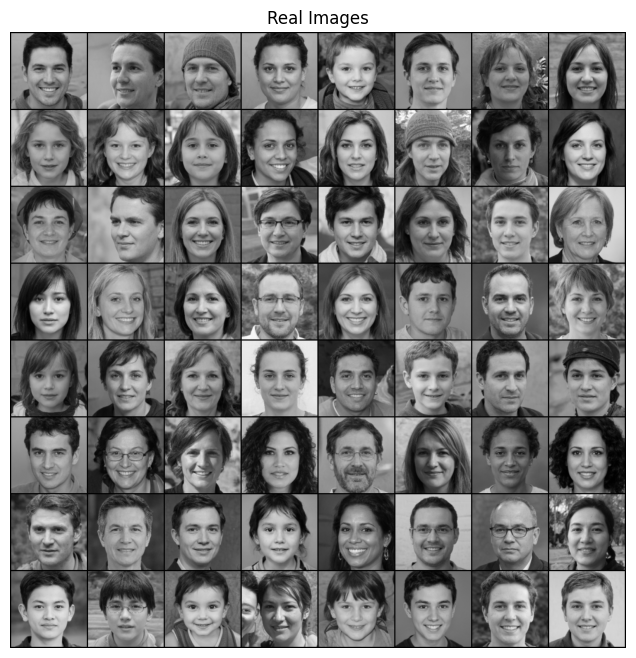

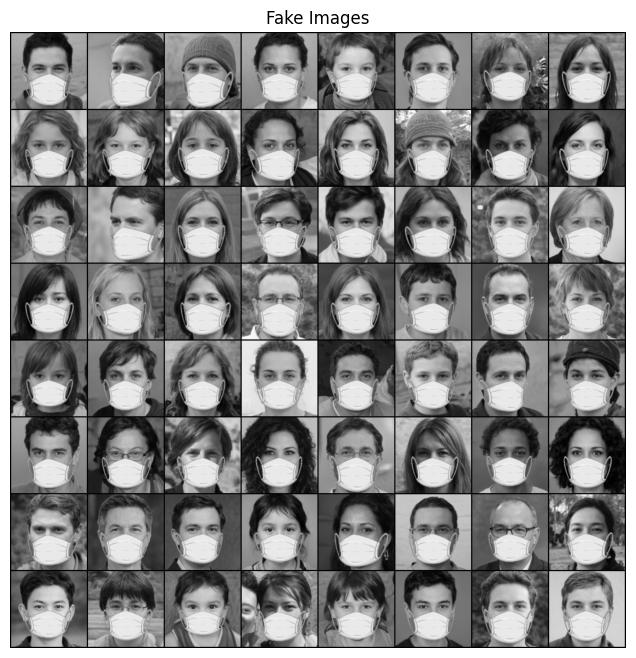

In [43]:
real_batch, fake_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake_batch[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [44]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [45]:


class Discriminator(nn.Module):
    def __init__(self, output_channels):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            
            nn.Conv2d(output_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
           
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64*2, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
           
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
           
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [46]:

class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()

        # downsize image (Encoder)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), #downsampling
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), #downsampling
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.encoder1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), #downsampling
    
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), #downsampling
    
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), #downsampling
    
        )
        # upsize  image (Decoder)
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),  # Upsampling
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # Upsampling
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
        )
        self.decoder1 = nn.Sequential(
            
            
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # Upsampling
            nn.ReLU(inplace=True),
        )
        self.decoder2 = nn.Sequential(
            
            
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Upsampling
            nn.ReLU(inplace=True),
        )
        self.decoder3 = nn.Sequential(
            
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Upsampling
            nn.ReLU(inplace=True),
        )

        # Output layer
        self.output = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        
        
        x = self.decoder1(x3) 
        x = self.decoder2(x + x2) #added skipconnection
        x = self.decoder3(x + x1) #added skipconnection
        
        x3 = self.output(x)
        return x3




In [47]:

netG = Generator(1,1)
netD = Discriminator(1)
netG.apply(weights_init)
netD.apply(weights_init)
print(netG)
print(netD)

Generator(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
  )
  (encoder1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=

In [48]:
# Initialize the ``BCELoss`` function
lr = 0.0002
beta1 = 0.5
criterion = nn.BCELoss()
img_criterion = nn.MSELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
real, fake = next(iter(dataloader))
fixed_faces = fake
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [55]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
img_losses = []
iters = 0
num_epochs = 1
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        real_image, fake_image = data
        
        # (1) Update Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = real_image
        fake_cpu = fake_image
        #real_cpu = data[0]
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        #noise = torch.randn(b_size, 3, 64, 64)
        # Generate fake image batch with G
        
        fake = netG(fake_image)
    
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        
        # (2) Update Generator: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)

        lossImg = img_criterion(fake,real_cpu)

        lossG = errG + lossImg
        # Calculate gradients for G
        lossG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tLoss_img:%.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(),lossImg.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        img_losses.append(lossImg.item())
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_faces).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        print("batch: " + str(iters))

Starting Training Loop...
[0/1][0/79]	Loss_D: 4.6737	Loss_G: 15.5877	Loss_img:0.3464	D(x): 0.9902	D(G(z)): 0.9298 / 0.0000
batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9


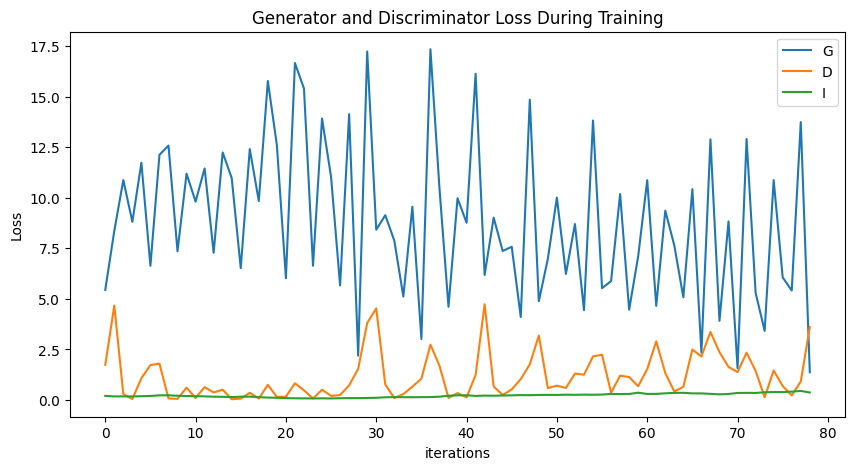

In [53]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.plot(img_losses,label="I")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

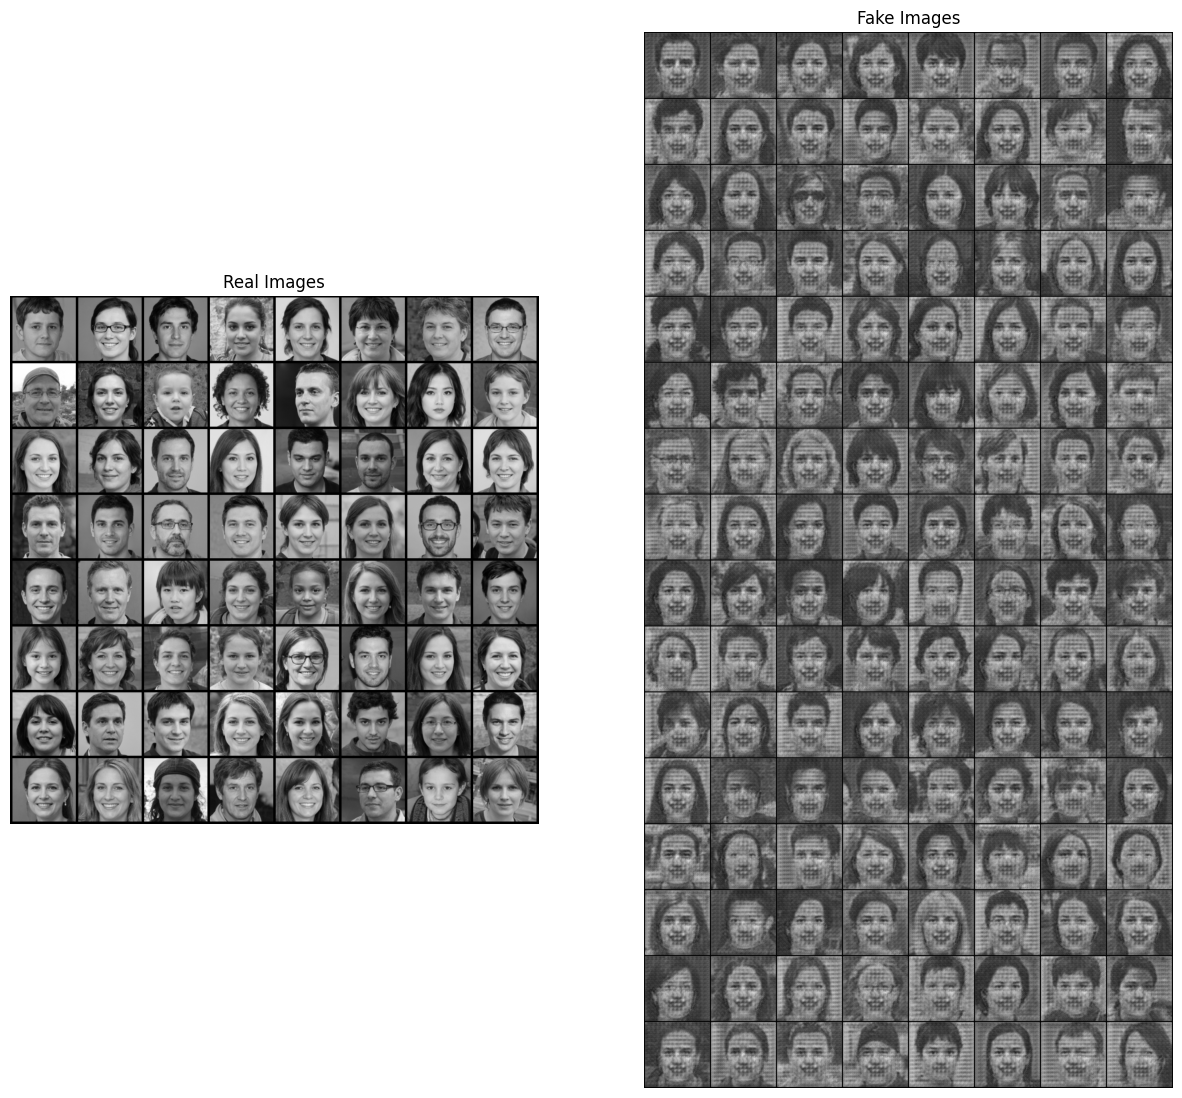

In [54]:
real_batch,fake_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1][:64],(1,2,0)))
plt.show()



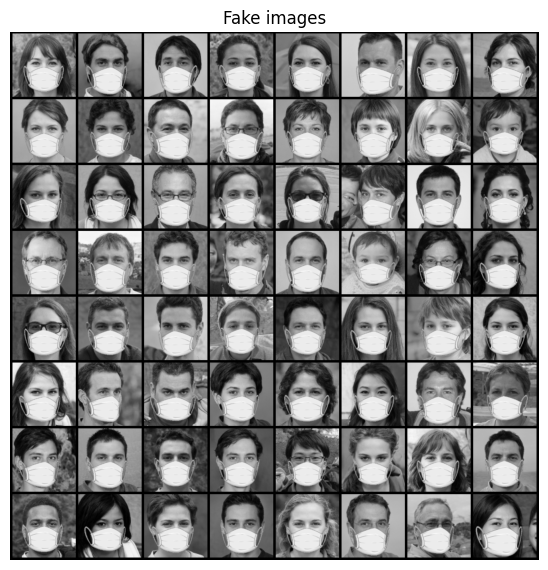

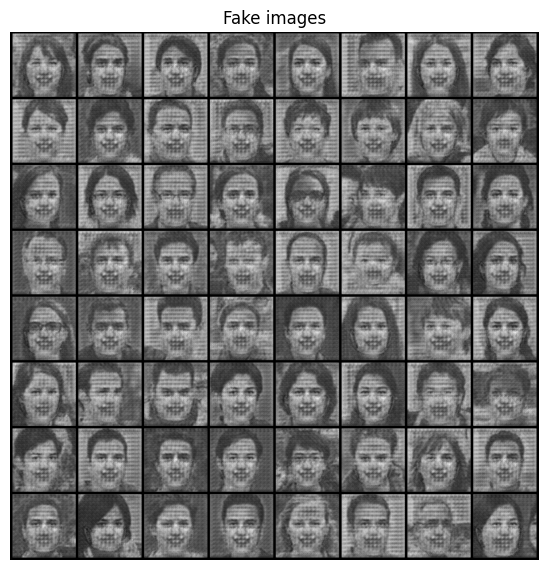

In [52]:
real_batch,fake_batch = next(iter(dataloader))
fake = netG(fake_batch)
img  = fake.detach()
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Fake images")
plt.imshow(np.transpose(vutils.make_grid(fake_batch[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Fake images")
plt.imshow(np.transpose(vutils.make_grid(img[:64], padding=5, normalize=True).cpu(),(1,2,0)))


